In [2]:
# Script based on notebook by chattob: https://www.kaggle.com/chattob
# Link https://www.kaggle.com/chattob/intel-mobileodt-cervical-cancer-screening/cervix-segmentation-gmm
__author__ = 'ZFTurbo: https://kaggle.com/zfturbo'

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import cv2
import math
from sklearn import mixture
from sklearn.utils import shuffle
from skimage import measure
from glob import glob
import os

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [16]:
TRAIN_DATA = "../input/train"
TEST_DATA = "../input/test"
ADDITIONAL_DATA = "../input/additional"
train_files = glob(os.path.join(TRAIN_DATA, "*", "*.jpg"))
test_files = glob(os.path.join(TEST_DATA, "*.jpg"))
additional_files = glob(os.path.join(ADDITIONAL_DATA, "*", "*.jpg"))

# train_files = train_files[:3]
# test_files = test_files[:3]
# additional_files = additional_files[:3]


def get_image_data(fname):
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def maxHist(hist):
    maxArea = (0, 0, 0)
    height = []
    position = []
    for i in range(len(hist)):
        if (len(height) == 0):
            if (hist[i] > 0):
                height.append(hist[i])
                position.append(i)
        else:
            if (hist[i] > height[-1]):
                height.append(hist[i])
                position.append(i)
            elif (hist[i] < height[-1]):
                while (height[-1] > hist[i]):
                    maxHeight = height.pop()
                    area = maxHeight * (i - position[-1])
                    if (area > maxArea[0]):
                        maxArea = (area, position[-1], i)
                    last_position = position.pop()
                    if (len(height) == 0):
                        break
                position.append(last_position)
                if (len(height) == 0):
                    height.append(hist[i])
                elif (height[-1] < hist[i]):
                    height.append(hist[i])
                else:
                    position.pop()
    while (len(height) > 0):
        maxHeight = height.pop()
        last_position = position.pop()
        area = maxHeight * (len(hist) - last_position)
        if (area > maxArea[0]):
            maxArea = (area, len(hist), last_position)
    return maxArea


def maxRect(img):
    maxArea = (0, 0, 0)
    addMat = np.zeros(img.shape)
    for r in range(img.shape[0]):
        if r == 0:
            addMat[r] = img[r]
            area = maxHist(addMat[r])
            if area[0] > maxArea[0]:
                maxArea = area + (r,)
        else:
            addMat[r] = img[r] + addMat[r - 1]
            addMat[r][img[r] == 0] *= 0
            area = maxHist(addMat[r])
            if area[0] > maxArea[0]:
                maxArea = area + (r,)
    return (
    int(maxArea[3] + 1 - maxArea[0] / abs(maxArea[1] - maxArea[2])), maxArea[2], maxArea[3], maxArea[1], maxArea[0])


def cropCircle(img):
    if (img.shape[0] > img.shape[1]):
        tile_size = (int(img.shape[1] * 256 / img.shape[0]), 256)
    else:
        tile_size = (256, int(img.shape[0] * 256 / img.shape[1]))

    img = cv2.resize(img, dsize=tile_size)

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)

    _, contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    main_contour = sorted(contours, key=cv2.contourArea, reverse=True)[0]

    ff = np.zeros((gray.shape[0], gray.shape[1]), 'uint8')
    cv2.drawContours(ff, main_contour, -1, 1, 15)
    ff_mask = np.zeros((gray.shape[0] + 2, gray.shape[1] + 2), 'uint8')
    cv2.floodFill(ff, ff_mask, (int(gray.shape[1] / 2), int(gray.shape[0] / 2)), 1)
    # cv2.circle(ff, (int(gray.shape[1]/2), int(gray.shape[0]/2)), 3, 3, -1)

    rect = maxRect(ff)
    img_crop = img[min(rect[0], rect[2]):max(rect[0], rect[2]), min(rect[1], rect[3]):max(rect[1], rect[3])]
    cv2.rectangle(ff, (min(rect[1], rect[3]), min(rect[0], rect[2])), (max(rect[1], rect[3]), max(rect[0], rect[2])), 3,
                  2)

    return img_crop


def Ra_space(img, Ra_ratio, a_threshold):
    imgLab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    w = img.shape[0]
    h = img.shape[1]
    Ra = np.zeros((w * h, 2))
    for i in range(w):
        for j in range(h):
            R = math.sqrt((w / 2 - i) * (w / 2 - i) + (h / 2 - j) * (h / 2 - j))
            Ra[i * h + j, 0] = R
            Ra[i * h + j, 1] = min(imgLab[i][j][1], a_threshold)

    Ra[:, 0] /= max(Ra[:, 0])
    Ra[:, 0] *= Ra_ratio
    Ra[:, 1] /= max(Ra[:, 1])

    return Ra


def show_rectangles(n, offset=0):
    counter = 0
    for f in sorted(train_files)[offset:]:
#     for f in sorted(additional_files):
        
#         if not 'Type_2' in f:
#             continue
        if int(os.path.basename(f)[:-4]) >= 3000:
            continue
        if 'Type_1/994.jpg' in f or 'Type_1/6914.jpg' in f:
            continue
        print('Go for {}'.format(f))
        img_id = os.path.basename(f)
        img_type = 'test'
        clss = -1
        if TRAIN_DATA in f:
            img_type = 'train'
            clss = int(os.path.basename(os.path.dirname(f)).split('_')[1]) - 1
        if ADDITIONAL_DATA in f:
            img_type = 'add'
            clss = int(os.path.basename(os.path.dirname(f)).split('_')[1]) - 1
        
        try:
            img = get_image_data(f)
        except:
            print('Image read error: {}. Skip it!'.format(f))
            continue
        if img is None:
            print('Problem with image: {}. Skip it!'.format(f))
            continue
        initial_shape = img.shape[:2]

        img = cropCircle(img)
        w = img.shape[0]
        h = img.shape[1]

        # Saturating the a-channel at 150 helps avoiding wrong segmentation
        # in the case of close-up cervix pictures where the bloody os is falsly segemented as the cervix.
        Ra = Ra_space(img, 1.0, 150)
        a_channel = np.reshape(Ra[:, 1], (w, h))        

        g = mixture.GaussianMixture(n_components=2, covariance_type='diag', random_state=0, init_params='kmeans')
        image_array_sample = shuffle(Ra, random_state=0)[:1000]
        g.fit(image_array_sample)
        labels = g.predict(Ra)
        labels += 1  # Add 1 to avoid labeling as 0 since regionprops ignores the 0-label.

        # The cluster that has the highest a-mean is selected.
        labels_2D = np.reshape(labels, (w, h))
        gg_labels_regions = measure.regionprops(labels_2D, intensity_image=a_channel)
        gg_intensity = [prop.mean_intensity for prop in gg_labels_regions]
        cervix_cluster = gg_intensity.index(max(gg_intensity)) + 1

        mask = np.zeros((w * h, 1), 'uint8')
        mask[labels == cervix_cluster] = 255
        mask_2D = np.reshape(mask, (w, h))
    
        cc_labels = measure.label(mask_2D, background=0)
        regions = measure.regionprops(cc_labels)
        areas = [prop.area for prop in regions]

        regions_label = [prop.label for prop in regions]
        largestCC_label = regions_label[areas.index(max(areas))]
        mask_largestCC = np.zeros((w, h), 'uint8')
        mask_largestCC[cc_labels == largestCC_label] = 255

        img_masked = img.copy()
        img_masked[mask_largestCC == 0] = (0, 0, 0)
        img_masked_gray = cv2.cvtColor(img_masked, cv2.COLOR_RGB2GRAY)
        
        _, thresh_mask = cv2.threshold(img_masked_gray, 0, 255, 0)

        kernel = np.ones((11, 11), np.uint8)
        thresh_mask = cv2.dilate(thresh_mask, kernel, iterations=1)
        thresh_mask = cv2.erode(thresh_mask, kernel, iterations=2)
        
        
        plt.figure(figsize=(12, 6))
        plt.subplot(1,5,1)
        plt.imshow(a_channel)

        plt.subplot(1,5,2)
        plt.imshow(mask_2D)

        plt.subplot(1,5,3)
        plt.imshow(img_masked)

        plt.subplot(1,5,4)
        plt.imshow(thresh_mask)
        
        imgLab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        plt.subplot(1,5,5)
        plt.imshow(imgLab[:,:,1])

        
        _, contours_mask, _ = cv2.findContours(thresh_mask.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

        try:
            main_contour = sorted(contours_mask, key=cv2.contourArea, reverse=True)[0]
        except:
            print('Contour problem for {}. skip it!'.format(f))
            continue

        x, y, w, h = cv2.boundingRect(main_contour)
        
        counter += 1
        if counter == n:
            break

Go for ../input/train/Type_1/1033.jpg
Go for ../input/train/Type_1/104.jpg
Go for ../input/train/Type_1/1040.jpg
Go for ../input/train/Type_1/1056.jpg
Go for ../input/train/Type_1/1059.jpg
Go for ../input/train/Type_1/1061.jpg
Go for ../input/train/Type_1/1070.jpg
Go for ../input/train/Type_1/1071.jpg
Go for ../input/train/Type_1/1077.jpg
Go for ../input/train/Type_1/1079.jpg


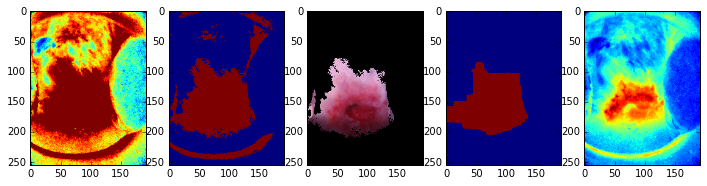

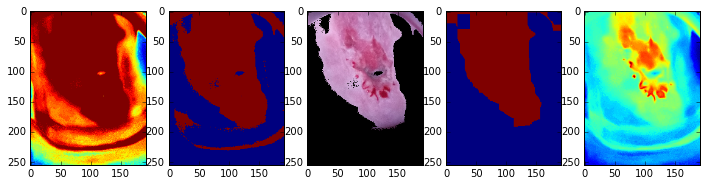

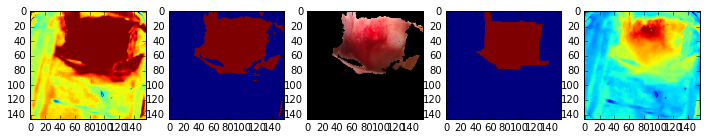

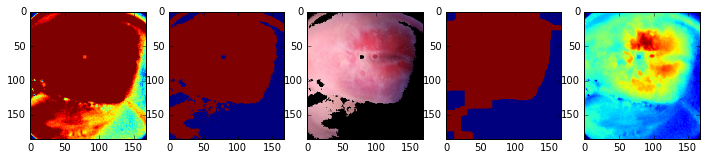

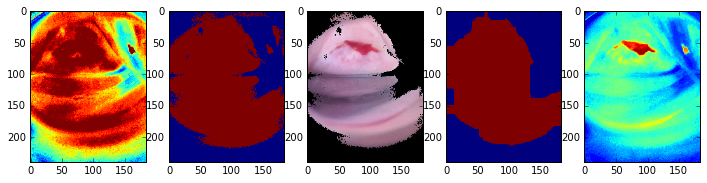

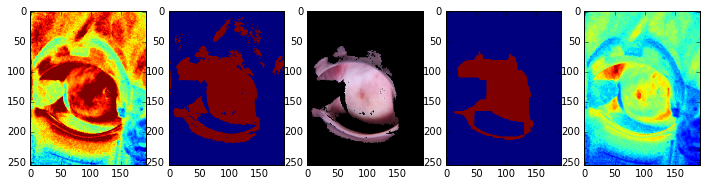

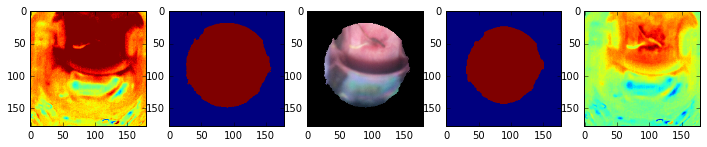

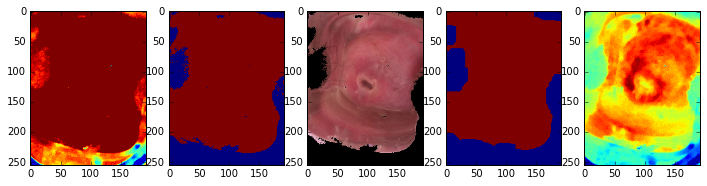

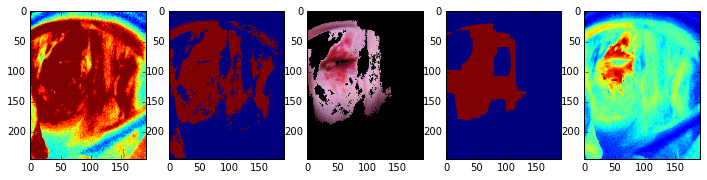

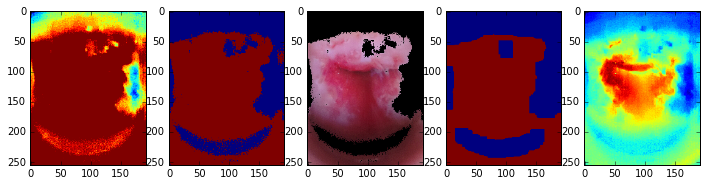

In [17]:
n=10
show_rectangles(n, 10)